In [39]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline
pd.set_option('display.max_columns', 500)


In [40]:
train = pd.read_csv('../data/clean_train_only_complete_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_only_complete_cols_chase.csv', parse_dates=['timestamp'], index_col="id")
macro = pd.read_csv('../data/macro_chase.csv',parse_dates=[0])


In [41]:
geo_df = pd.read_csv('../data/Longitud_Latitud.csv')
geo_df.columns = ['no', 'sub_area', 'lon', 'lat']
coords = geo_df.as_matrix(columns=['lat', 'lon'])

In [42]:
train_index = train.index.tolist()
test_index = test.index.tolist()

# cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
#         'sub_area','kremlin_km','price_doc','timestamp','price_full']

tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = list(set(tr_cols).intersection(te_cols))
cols.append('price_doc')

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)

df['month'] = df.timestamp.dt.month.astype(object)

In [43]:
# http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
def getClusters(coords,km_radius):
    kms_per_radian = 6371.0088
    epsilon = km_radius / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    return db.labels_



In [44]:
geo_df['new_group_id'] = getClusters(coords,5.5)
geo_df.new_group_id = geo_df.new_group_id.astype(object)

In [45]:
# this is just to check to see if new_group is already in the df
if 'new_group_id' in df.columns.tolist():
    df.drop('new_group_id',axis=1,inplace=True)
df = pd.merge(df,geo_df[['sub_area','new_group_id']],
              how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

In [46]:
macro['quarter'] = pd.PeriodIndex(macro['Unnamed: 0'], freq='Q').strftime('%qQ%y')
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('%qQ%y')

df = pd.merge(df,macro[['quarter','nominal_index']], how="left", on="quarter").reset_index(drop=True).set_index(df.index)
df['real_price_doc'] = df.price_doc / df.nominal_index

In [47]:
# moscow = moscow[moscow.date > df.timestamp.min()]
# moscow.reset_index(drop=True,inplace=True)
# moscow['nominal_index'] = moscow.price / moscow.price[0] 

In [48]:
# moscow = pd.read_csv('../data/moscow_index.csv',header=None,parse_dates=[0])
# moscow.columns = ['date','price']

# df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')
# df = pd.merge(df,moscow[['month_year','nominal_index']], how="left", on="month_year").reset_index(drop=True).set_index(df.index)

In [49]:
# cleaning up names
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

In [50]:
df['kitch_to_life'] = df.kitch_sq / df.life_sq
df['life_to_full'] = df.life_sq / df.full_sq
df['walk_up_penalty'] = 0
df.loc[(df.floor>4) & (df.max_floor < 6),'walk_up_penalty'] = 1 

## Helper Functions

In [51]:
def addMultiples(df):
    df['price_full'] = df.price_doc / df.full_sq
    df['real_price_full'] = df.real_price_doc / df.full_sq
    df['real_price_class'] = pd.qcut(df.real_price_full, 5, labels=["E","D","C","B","A"])

## Decision Tree Classifier

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [53]:
# creating a variable for how expensive the property is    
addMultiples(df)

## dropping outliers
outliers = df[df.real_price_full < 30000].copy()
df.drop(outliers.index,axis=0, inplace=True)
for x in outliers.index.tolist():
    train_index.remove(x)
    

# drop_cols = ['timestamp','price_doc','price_full','okurg_district','sub_area']
keep_cols = ['new_group_id','kremlin_km','floor','full_sq','product_type','full_sq','kitch_sq','max_floor','life_sq','sub_area']

# dataset
df_tcl = df[keep_cols].copy()


# dummify
df_obj = df_tcl.select_dtypes(include=['object']).copy()
df_num = df_tcl.select_dtypes(exclude=['object']).copy()

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)


In [54]:
tree_clf = DecisionTreeClassifier(max_depth=5)

x = df_all.loc[train_index,:]
y = df.loc[train_index,'real_price_class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
tree_clf.fit(x_train,y_train)

1.0 * sum(tree_clf.predict(x_test) == y_test) / len(y_test)


0.5079465319440059

In [55]:
df.loc[test_index,'real_price_class'] = tree_clf.predict(df_all.loc[test_index,:])

multiples = df.loc[train_index,['real_price_class','real_price_full']].groupby('real_price_class').median().to_dict()


df.loc[test_index,'real_price_full'] = df.real_price_class.apply(lambda x: multiples['real_price_full'].get(x))

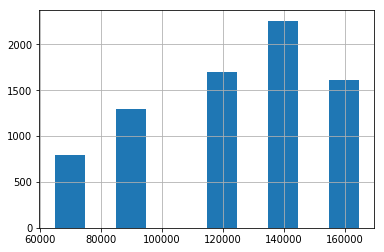

In [56]:
df.loc[test_index,'real_price_full'].hist()

## Decision Tree Regression
based on price multiple

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [58]:
drop_cols = ['timestamp','real_price_class','price_doc','real_price_full','quarter','real_price_doc','price_full']
df_trg = df.drop(drop_cols,axis=1)

df_obj = df_trg.select_dtypes(include=['object']).copy()
df_num = df_trg.select_dtypes(exclude=['object']).copy()

# df = df[keep_cols]
# df_obj = df.select_dtypes(include=['object'])
# df_num = df.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

df_all = df_all.apply(lambda x: x.astype(float)) 



tree_reg = DecisionTreeRegressor(max_depth=5)

x = df_all.loc[train_index,:]
y = df.loc[train_index,'real_price_full']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
tree_reg.fit(x_train,y_train)
print tree_reg.score(x_test,y_test)

0.505120393382


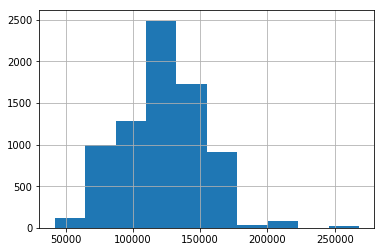

In [59]:
df.loc[test_index,'real_price_full'] = tree_reg.predict(df_all.loc[test_index,:])
df.loc[test_index,'real_price_doc'] = df.loc[test_index,'full_sq'] * df.loc[test_index,'real_price_full']
df.loc[test_index,'real_price_full'].hist()

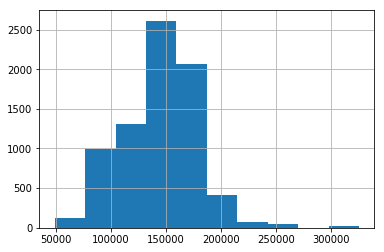

In [60]:
df.price_doc = df.real_price_doc * df.nominal_index

addMultiples(df)
df.loc[test_index,'price_full'].hist()

In [61]:
# 0.33925
# df.loc[test_index,'price_doc'].to_frame().to_csv('../submissions/decision_tree_price_multiple_052817.csv')

## Decision Tree Regressor 
price_doc

In [62]:
drop_cols = ['timestamp','real_price_class','price_doc','real_price_full','quarter','real_price_doc','price_full']
df_trg = df.drop(drop_cols,axis=1)

df_obj = df_trg.select_dtypes(include=['object']).copy()
df_num = df_trg.select_dtypes(exclude=['object']).copy()

# df = df[keep_cols]
# df_obj = df.select_dtypes(include=['object'])
# df_num = df.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

df_all = df_all.apply(lambda x: x.astype(float)) 



tree_reg = DecisionTreeRegressor(max_depth=5)

x = df_all.loc[train_index,:]
y = df.loc[train_index,'real_price_doc']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
tree_reg.fit(x_train,y_train)
print tree_reg.score(x_test,y_test)

0.642227824154


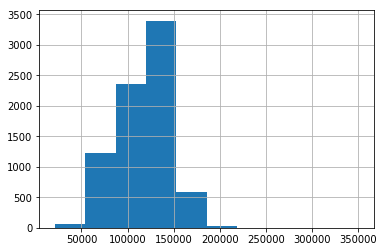

In [63]:
df.loc[test_index,'real_price_doc'] = tree_reg.predict(df_all.loc[test_index,:])
addMultiples(df)
df.loc[test_index,'real_price_full'].hist()
# df.loc[test_index,'real_price_full'].hist()

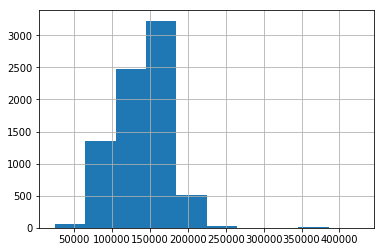

In [64]:
df.loc[test_index,'price_doc'] = df.loc[test_index,'nominal_index'] * df.loc[test_index,'real_price_doc']
addMultiples(df)
df.loc[test_index,'price_full'].hist()

In [65]:
# kaggle 0.36506
# df.loc[test_index,'price_doc'].to_frame().to_csv('../submissions/decision_tree_price_doc_052817.csv')